<a href="https://colab.research.google.com/github/tkdforever18/Carlos/blob/main/IA%20y%20ML%20-%20Actividad%20Semana%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Maestría en Analítica de Negocios**
## **Curso: Inteligencia Artificial y Aprendizaje Automático**
### Tecnológico de Monterrey
### Prof Luis Eduardo Falcón Morales

### **Semana 3 y 4 - ejercicios en clase - Caso Clasificación**
## **Importancia de Factores y Clases no balanceadas**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
X, y = make_classification(
       n_samples=2000,          # Se generan "n" registros donde cada factor tiene una distribución gaussiana con varianza 1.
       n_classes=2,             # El conjunto de datos generado constará de dos clases diferentes.
       n_features=2,            # Habrá 2 variables de entrada (factores o variables independientes)
       n_redundant=0,           # No hay factores que sean redundantes, i.e., que uno sea combinación lineal de otros factores.
       n_clusters_per_class=1,  # Cada clase se agrupa alrededor de un único centro.
       weights=[.9, .1],        # [proporción_clase_negativa(0), proporción_clase_positiva(1)]  : p1=1-p0
       flip_y=0.,               # No existen datos mal etiquetados.
       class_sep=0.35,           # Valor que indican la distancia entre clases. Más grande, mayor distancia.
       random_state=0)

Dimensión de datos generados:
Datos de entrada X: (2000, 2)
Variable de salida y: (2000,)


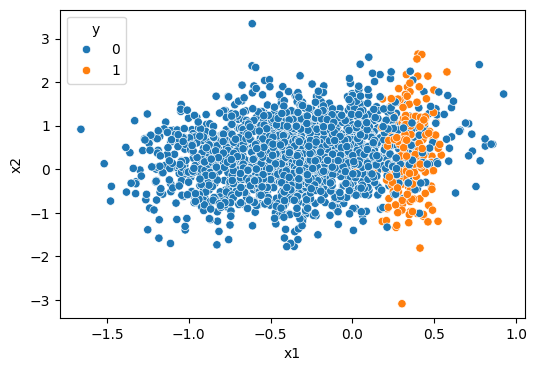

In [3]:
print('Dimensión de datos generados:')
print('Datos de entrada X:', X.shape)
print('Variable de salida y:', y.shape)

# Los transformamos en un DataFrame de Pandas:
df = pd.DataFrame(X, columns=['x1','x2'])
df['y'] = y

plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x='x1', y='x2', hue='y');

In [4]:
X_train, Xvt, y_train, yvt = train_test_split(X, y, train_size=0.60, random_state=1, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.50, random_state=1, stratify=y)

In [5]:
# Verificamos el porcentaje de la clase positiva y negativa, generados:
print('Porcentaje de la clase minoritaria: %.2f%%' % (100.*(y_val.sum() / y_val.shape[0])))

Porcentaje de la clase minoritaria: 10.00%


In [6]:
# Utilizemos el modelo de regresión logística:

modelo = LogisticRegression()

# Entrenamos con los datos de entrenamiento:
modelo.fit(X_train, y_train)

# Veamos el desempeño en cuanto exactitud (accuracy) del modelo con
# los datos de entrenamiento y validación, para verificar si nuestro
# modelo está subentrenado o sobreentrenado:
print('Exactitud del modelo con los datos de entrenamiento: %.1f%%' % (100*modelo.score(X_train,y_train)))
print('Exactitud del modelo con los datos de validación: %.1f%%' % (100*modelo.score(X_val,y_val)))

Exactitud del modelo con los datos de entrenamiento: 90.7%
Exactitud del modelo con los datos de validación: 90.4%


Aunque pareciera que tenemos un buen desempeño y que el modelo no está sobre-entrenado, en realidad el modelo está sub-entrenado. Esto ya que se tiene un porcentaje igual al porcentaje de la clase mayoritaria, que es del 90%.

In [7]:
# Realizamos las predicciones
y_hat_val = modelo.predict(X_val)

print(confusion_matrix(y_val, y_hat_val))
print(classification_report(y_val, y_hat_val))

[[875  25]
 [ 71  29]]
              precision    recall  f1-score   support

           0       0.92      0.97      0.95       900
           1       0.54      0.29      0.38       100

    accuracy                           0.90      1000
   macro avg       0.73      0.63      0.66      1000
weighted avg       0.89      0.90      0.89      1000



Aquí observamos cómo los valores de las métricas "precision", "recall" y por lo tanto su promedio armónico "f1-score", son bastante bajos. Lo que nos habla de la poca capacidad de poder predecir correctamente los datos de la clase de interés, la clase positiva.

Veamos si podemos mejorar el modelo con alguna técnica de sub-entrenamiento o sobre-entrenamiento.

Existe una gran variedad de estas técnicas, algunas de las cuales implementaremos de la librería de Imbalanced-learn:

https://imbalanced-learn.org/stable/references/under_sampling.html

https://imbalanced-learn.org/stable/references/over_sampling.html

https://imbalanced-learn.org/stable/references/combine.html

In [8]:
from imblearn.over_sampling import BorderlineSMOTE

In [9]:
bsm = BorderlineSMOTE(sampling_strategy=1.,  # porcentaje de nuvoes datos minoritario-vs-mayoritario
                      random_state=11)

# ajustamos y generamos los datos sobre-muestrados (over-sampling)
# con los datos de entrenamiento:
Xtrain_BSM, ytrain_BSM = bsm.fit_resample(X_train, y_train)

# Entrenamos el modelo con los nuevos datos muestrales de entrenamiento:
modeloRL = LogisticRegression(C=10)
modeloRL.fit(Xtrain_BSM, np.ravel(ytrain_BSM))

print('accuracy-train-balanced', modeloRL.score(Xtrain_BSM, ytrain_BSM))
print('accuracy-val-balanced', modeloRL.score(X_val, y_val))

y_pred_train = modeloRL.predict(Xtrain_BSM)

# Observa que en X_val no se aplica el sobremuestreo,
# para evitar el filtrado de información (data-leakage):
y_pred_val = modeloRL.predict(X_val)

print(confusion_matrix(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))

accuracy-train-balanced 0.95
accuracy-val-balanced 0.903
[[803  97]
 [  0 100]]
              precision    recall  f1-score   support

           0       1.00      0.89      0.94       900
           1       0.51      1.00      0.67       100

    accuracy                           0.90      1000
   macro avg       0.75      0.95      0.81      1000
weighted avg       0.95      0.90      0.92      1000



Observa que ahora tenemos un Recall=1.00 en la clase positiva, sin embargo la precision bajo al 50%. Además de quedar sobre-entrenado.

Habría que buscar un mejor balance ajustando hiperparámetros del modelo o de la técnica de sobre-muestreo, o bien probar algún otro de los modelos de sub-muestreo y/o sobre-muestreo. Ver los difernentes métodos en las ligas dadas arriba.

# Importancia de los Factores

Existen varias técnicas para evaluar la importancia de los factores en relación al involucramiento que tiene cada factor con la variable de salida.

Veamos algunos de ellos.

### Magnitud de los coeficientes.

Este es una técnica muy simple que debe aplicarse cuando los factores han sido todos escalados de manera equivalente. Sin embargo, debe tomarse con mucha cautela esta técnica, ya que no necesariamente la magnitud por sí misma es indicio de mayor involucramiento en la predicción de la variable de salidad. Esto porque pueden existir relaciones entre combinación de factores que disminuya la importancia de dicho factor. En dado caso siempre intenta algunas de las otras técnicas que estaremos viendo más adelante. Pero como una primera aproximación, puede considerarse aceptable.

In [10]:
# consideremos los coeficientes obtenidos en el último modelo obtenido:
importance = modeloRL.coef_[0]

# Veamos la magnitud de nuestro modelo, que en este caso es solo de de factores (features):
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 12.49683
Feature: 1, Score: -0.26727


Observamos que definitivamente el factor 0 es el de mayor relevancia para predecir la clase.
Geométricamente tiene sentido, porque si observamos la gráfica obtenida al inicio, el factor 0 está asociado al eje horizontal y por lo tanto, y geométricamente observamos que aproximadamente a la izquierda del valor de 0.25 en el eje horizontal se tiene puntos de la clase mayoritaria y a la derecha los de la clase minoritaria.

Observa que el signo positivo de los coeficientes nos habla sobre la influencia de dicho coeficiente sobre la clase positiva (minoritaria en este caso) y los coeficientes negativos nos hablaría sobre el impacto de estos sobre la clase negativa.

Valores cercanos al cero, como en este caso el factor 1, no tendría mucha influencia sobre el comportamiento de la varible de salida.

# Importancia por Permutación

Veamos ahora esta otra técnica más robusta y que aplica también a otros modelos no lineales y no solamente a los modelos de regresión.

Puedes revisar la documentación para mayor información:

https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html

In [11]:
from sklearn.inspection import permutation_importance

In [12]:
# Usemos nuevamente el modelo de regresión logística previamente entrenado:

results = permutation_importance(modeloRL, X_val, y_val, scoring='recall')

importance = results.importances_mean

for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.81800
Feature: 1, Score: 0.00200


Además, la ventaja de este método es que nos permite evaluar el impacto de los factores con respecto a diferentes métricas y no solamente el "accuracy" o exactitud. En particular, para el caso de clases no balanceadas, como en este ejercicio, es mejor considerar métricas como el recall, la precision, o su promedio armónico f1, o el ponderado, f1_weighted.

# Selección de Factores mediante el criterio de la Importancia de los mismos.

Puedes consultar su documentación en la siguiente liga:
    
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html

In [13]:
from sklearn.feature_selection import SelectFromModel

In [14]:
# Con base a los resultados con las técnicas de Importancia de Factores,
# se propone el conjunto de factores que se consideran importantes.
# Para nuestro ejemplo muy sencillo obtuvimos que es solo 2 factor:
max_f = 1

# Indicamos el modelo que se usará para evaluar la importancia de los factores
# y la cantidad de ellos que se desean extraer:
fs = SelectFromModel(estimator=LogisticRegression(), max_features=max_f)
# ajustamos con  los datos de entrenamiento para determinar cuáles se consideran los más relevantes:
fs.fit(X_train, np.ravel(y_train))
# y ahora obtenemos los factores
factor_select = fs.get_support()

print(factor_select)

[ True False]


Obtenemos nuevamente que el primer factor es el más relevante en este caso.

Y seleccionamos entonces solamente los factores o columnas obtenidas en nuestro DataFrame:

In [15]:
XtrainT_fs = pd.DataFrame(X_train)[pd.DataFrame(X_train).columns[factor_select]]
XvalT_fs = pd.DataFrame(X_val)[pd.DataFrame(X_val).columns[factor_select]]
XtestT_fs = pd.DataFrame(X_test)[pd.DataFrame(X_test).columns[factor_select]]

In [16]:
XtrainT_fs # y en este caso solo tenemos una columna o factor en nuestro DataFrame.

,0
0,-0.661456
1,-0.131180
2,-0.338835
3,-0.345142
4,-0.254506
...,...
1195,-0.480640
1196,0.048735
1197,-0.017955
1198,-0.326542


In [17]:
modeloRL = LogisticRegression()
#modeloRL.fit(pd.DataFrame(X_train)[pd.DataFrame(X_train).columns[factor_select]], pd.DataFrame(y_train).values)
modeloRL.fit(XtrainT_fs, np.ravel(pd.DataFrame(y_train)))

# evaluate the model
#ytrainhat = model.predict(Xtrain_fs)
#yvalhat = model.predict(Xval_fs)
#ytesthat = model.predict(Xtest_fs)

# evaluate predictions
R2train = modeloRL.score(XtrainT_fs, np.ravel(y_train))
R2val = modeloRL.score(XvalT_fs, np.ravel(y_val))
R2test = modeloRL.score(XtestT_fs, np.ravel(y_test))

print('R2-Train: %.2f' % (R2train*100))
print('R2-Val: %.2f' % (R2val*100))
print('R2-Test: %.2f' % (R2test*100))

R2-Train: 90.08
R2-Val: 89.80
R2-Test: 89.70


Estos nuevos DataFrame los usaríamos para entrenar un nuevo modelo, con esta reducción de dimensionalidad.

### **>> Fin del ejemplo de esta semana <<**